# Common Pool Resource with Single Agent

In [1]:
using MultiAgentEmergence
using POMDPs
using POMDPPolicies
using POMDPSimulators
using POMDPModelTools

┌ Info: Precompiling MultiAgentEmergence [6efdc3e2-65f5-49e0-b0e5-5cf75fc7274f]
└ @ Base loading.jl:1342
┌ Warning: Error requiring `UnicodePlots` from `Plots`
│   exception = (LoadError("/Users/liamsmith/.julia/packages/Plots/5kcBO/src/backends/unicodeplots.jl", 77, UndefVarError(:UserColorType)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000010f3ed2cf, Ptr{Nothing} @0x000000010f4812a1, Ptr{Nothing} @0x0000000114c1cd52, Ptr{Nothing} @0x000000010f46bfbf, Ptr{Nothing} @0x000000010f48325f, Ptr{Nothing} @0x000000010f481b94, Ptr{Nothing} @0x000000010f481f0c, Base.InterpreterIP in top-level CodeInfo for Plots at statement 3, Ptr{Nothing} @0x000000010f49c844, Ptr{Nothing} @0x000000010f49c604, Ptr{Nothing} @0x000000010f49d134, Ptr{Nothing} @0x0000000114fe54e7, Ptr{Nothing} @0x000000010f46bfbf, Ptr{Nothing} @0x0000000115036312, Ptr{Nothing} @0x0000000114c6ca65, Ptr{Nothing} @0x000000010f46bfbf, Ptr{Nothing} @0x000000010f478839, Ptr{Nothing} @0x0000000121daf0ae, Ptr{Nothing} @0

In [2]:
# Global Settings
hr = HistoryRecorder(max_steps = 1000)
pomdp = CommonPool()
POMDPs.observation(s::CommonPoolState) = POMDPs.observation(pomdp, s)
map = DefaultMap(pomdp)
POMDPs.initialstate_distribution(m::CommonPool) = Deterministic(map)

episodes = 50

50

## Random Policy
Move in random direction

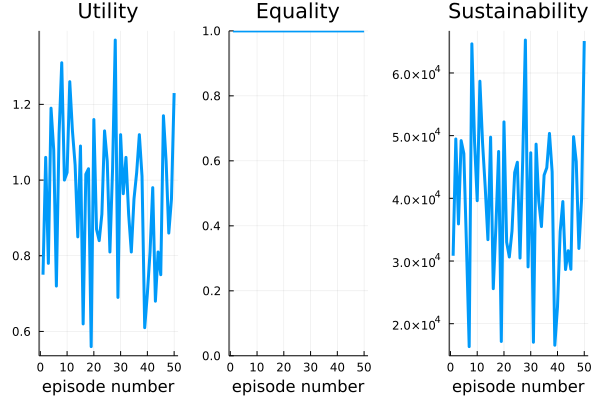

In [7]:
policy_random = random_policy
harray_random = []
for i in 1:episodes 
    push!(harray_random, simulate(hr, pomdp, policy_random))
end
plot_socials(harray_random)

In [ ]:
# Gif of one episode
ep_num = rand(1:length(harray_random))
h = harray_random[ep_num]
for (s, a, sp) in eachstep(h)
    IJulia.clear_output(true)
    display(render(pomdp, (s=sp,a=a)))
    sleep(1/60) # 60 fps
end

# This would work if render returns a plot object from Plots.jl
#@gif for (s, a, r, sp) in eachstep(h)
#    render(mdp, (s=s,a=a))
#end

## Greedy Policy
Move in direction of most resources (observation range radius: 3)

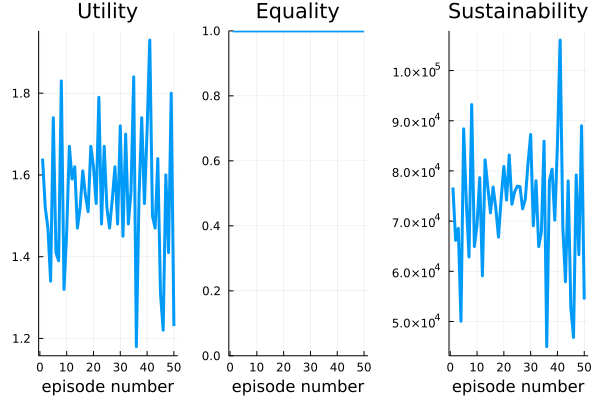

In [6]:
obs_range = 3
POMDPs.observation(m::CommonPool, s::CommonPoolState) = POMDPs.observation(m, s, obs_range)
POMDPs.observation(s::CommonPoolState) = POMDPs.observation(pomdp, s, obs_range)

policy_greedy = greedy_policy
harray_greedy = []
for i in 1:episodes 
    push!(harray_greedy, simulate(hr, pomdp, policy_greedy))
end
plot_socials(harray_greedy)

In [ ]:
# Gif of one episode
ep_num = rand(1:length(harray_greedy))
h = harray_greedy[ep_num]
for (s, a, sp) in eachstep(h)
    IJulia.clear_output(true)
    display(render(pomdp, (s=sp,a=a)))
    sleep(1/60) # 60 fps
end

## Path Policy
Follow predefined path

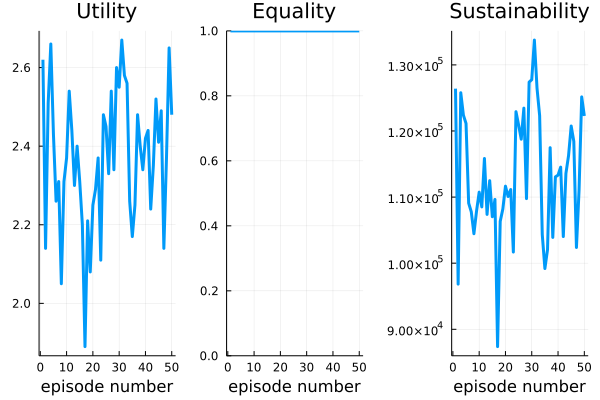

In [8]:
policy_path = path_policy(pomdp,map)
harray_path = []
for i in 1:episodes 
    push!(harray_path, simulate(hr, pomdp, policy_path))
    policy_path = path_policy(pomdp,map) # reset the path each iteration
end
plot_socials(harray_path)

In [ ]:
# Gif of one episode
ep_num = rand(1:length(harray_path))
h = harray_path[ep_num]
for (s, a, sp) in eachstep(h)
    IJulia.clear_output(true)
    display(render(pomdp, (s=sp,a=a)))
    sleep(1/60) # 60 fps
end

## DQN Policy

In [3]:
using DeepQLearning
using Flux

In [4]:
obs_range = 4
POMDPs.observation(m::CommonPool, s::CommonPoolState) = POMDPs.observation(m, s, obs_range)
POMDPs.initialobs(m::CommonPool, s::CommonPoolState) = POMDPs.observation(m, s, obs_range)

#POMDPs.observation(s::CommonPoolState) = POMDPs.observation(m, s, obs_range)
#POMDPs.initialobs(m::CommonPool, s::CommonPoolState) = POMDPs.observation(m, s, obs_range)

#DQN
model = Chain(Dense((2*obs_range+1)^2, 32), Dense(32, 32), Dense(32, length(actions(pomdp))))
exploration = EpsGreedyPolicy(pomdp, LinearDecaySchedule(start=1.0, stop=0.01, steps=10000/2))
solver = DeepQLearningSolver(qnetwork = model, max_steps=10000, 
                             exploration_policy = exploration,
                             learning_rate=0.005,log_freq=1000,
                             recurrence=false,double_q=true, dueling=true, prioritized_replay=true)
policy_dqn = solve(solver, pomdp)

Evaluation ... Avg Reward 177.00 | Avg Step 101.00 
 1000 / 10000 eps 0.802 |  avgR 170.000 | Loss 2.208e+00 | Grad 2.624e-01 | EvalR 177.000 
Evaluation ... Avg Reward 0.00 | Avg Step 101.00 
Evaluation ... Avg Reward 84.30 | Avg Step 101.00 
 2000 / 10000 eps 0.604 |  avgR 183.333 | Loss 3.751e+00 | Grad 1.572e+00 | EvalR 84.300 
Evaluation ... Avg Reward 124.20 | Avg Step 101.00 
Evaluation ... Avg Reward 138.20 | Avg Step 101.00 
 3000 / 10000 eps 0.406 |  avgR 198.065 | Loss 2.822e+00 | Grad 5.197e-01 | EvalR 138.200 
Evaluation ... Avg Reward 111.40 | Avg Step 101.00 
Saving new model with eval reward 111.400 
Evaluation ... Avg Reward 146.50 | Avg Step 101.00 
 4000 / 10000 eps 0.208 |  avgR 204.146 | Loss 5.163e+00 | Grad 6.733e+00 | EvalR 146.500 
Evaluation ... Avg Reward 53.30 | Avg Step 101.00 
Evaluation ... Avg Reward 125.90 | Avg Step 101.00 
 5000 / 10000 eps 0.010 |  avgR 211.569 | Loss 6.886e+00 | Grad 4.457e+00 | EvalR 125.900 
Evaluation ... Avg Reward 281.00 | Avg 

NNPolicy{CommonPool, DeepQLearning.DuelingNetwork, Symbol}(CommonPool(9, 9, Dict(:left => 2, :right => 1, :up => 4, :down => 3), 10, 0.99), DeepQLearning.DuelingNetwork(Chain(), Chain(Dense(81, 32), Dense(32, 32), Dense(32, 1)), Chain(Dense(81, 32), Dense(32, 32), Dense(32, 4))), [:up, :down, :left, :right], 1)

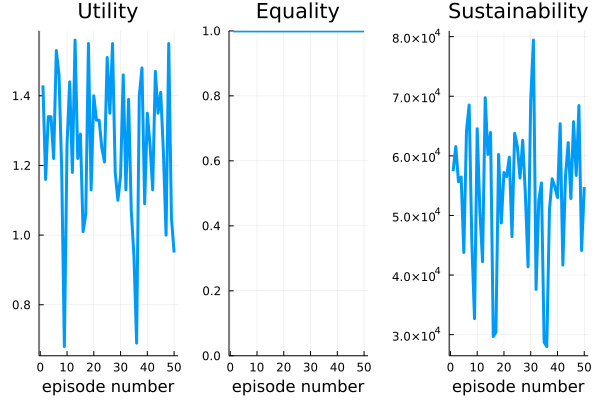

In [5]:
harray_dqn = []
for i in 1:episodes 
    push!(harray_dqn, simulate(hr, pomdp, policy_dqn))
end
plot_socials(harray_dqn)

In [ ]:
# Gif of one episode
ep_num = rand(1:length(harray_dqn))
h = harray_dqn[ep_num]
for (s, a, sp) in eachstep(h)
    IJulia.clear_output(true)
    display(render(pomdp, (s=sp,a=a)))
    sleep(1/60) # 60 fps
end

## Compare Policies

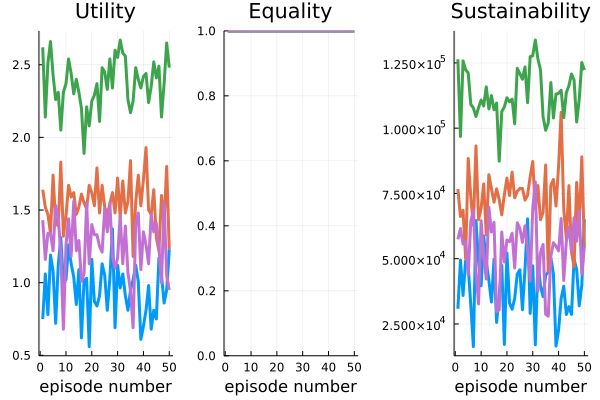

In [9]:
p1 = plot_socials(harray_random)       # blue
p2 = plot_socials!(p1, harray_greedy)  # red
p3 = plot_socials!(p2, harray_path)    # green
p4 = plot_socials!(p3, harray_dqn)     # purple